본 실습은 Marco Peixeiro의 Time Series Forecasting in Python 책과 코드를 참조해 만들었다.

본 코드는 https://github.com/jpub-dongdong9/TimeSeriesForecastingInPython/tree/master 에서도 찾을 수 있다.

지금까지는 통계적 모델을 활용한 시계열 예측을 중점적으로 다루었다.

하지만 데이터 집합이 매우 크거나 고차원 시계열 데이터의 경우 (데이터 요소가 10,000개 이상), 통계적 모델이 부적합하다.

지금부터는 딥러닝을 활용한 시계열 예측에 대해 알아보고자 한다.

# Data

## Data preprocessing

### 필요한 패키지 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 데이터 로드

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/Metro_Interstate_Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### 데이터 전처리

In [3]:
df['date_time']

0        2012-10-02 09:00:00
1        2012-10-02 10:00:00
2        2012-10-02 11:00:00
3        2012-10-02 12:00:00
4        2012-10-02 13:00:00
                ...         
48199    2018-09-30 19:00:00
48200    2018-09-30 20:00:00
48201    2018-09-30 21:00:00
48202    2018-09-30 22:00:00
48203    2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: object

In [4]:
#Object -> datetime
df['date_time'] = pd.to_datetime(df['date_time'])

In [5]:
#중복행 제거
df = df.drop_duplicates(subset='date_time', ignore_index=True)

In [6]:
df.shape

(40575, 9)

In [7]:
#데이터 범위 설정
date_range = list(pd.date_range('2016-09-29 17:00:00', '2018-09-30 23:00:00', freq='H'))
print(len(date_range))

new_df = pd.DataFrame({'date_time': date_range})

17551


In [8]:
#불필요한 column 제거
full_df = pd.merge(new_df, df, how='left', on='date_time')
full_df = full_df.drop(['holiday', 'weather_main', 'weather_description'], axis=1)

In [9]:
full_df

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0.0,0.0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0.0,0.0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0.0,0.0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0.0,0.0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0.0,0.0,2443.0
...,...,...,...,...,...,...
17546,2018-09-30 19:00:00,283.45,0.0,0.0,75.0,3543.0
17547,2018-09-30 20:00:00,282.76,0.0,0.0,90.0,2781.0
17548,2018-09-30 21:00:00,282.73,0.0,0.0,90.0,2159.0
17549,2018-09-30 22:00:00,282.09,0.0,0.0,90.0,1450.0


In [10]:
full_df.isna().sum()

date_time           0
temp              104
rain_1h           104
snow_1h           104
clouds_all        104
traffic_volume    104
dtype: int64

In [11]:
#결측치 채우기
full_df = full_df.fillna(full_df.groupby(full_df.date_time.dt.hour).transform('median'))

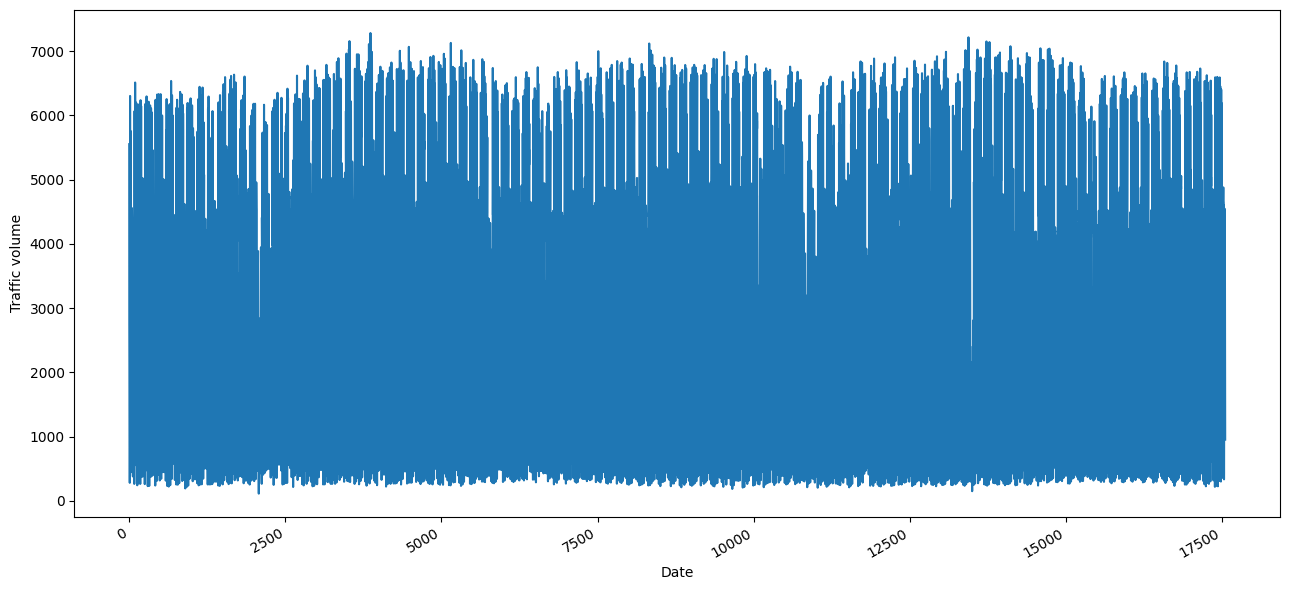

In [12]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(full_df.traffic_volume)
ax.set_xlabel('Date')
ax.set_ylabel('Traffic volume')

fig.autofmt_xdate()
plt.tight_layout()

## Visualization

### 필요한 패키지 불러오기

In [13]:
import warnings
warnings.filterwarnings('ignore')

import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

### 데이터 불러오기

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/metro_interstate_traffic_volume_preprocessed.csv')
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


### 교통량 데이터

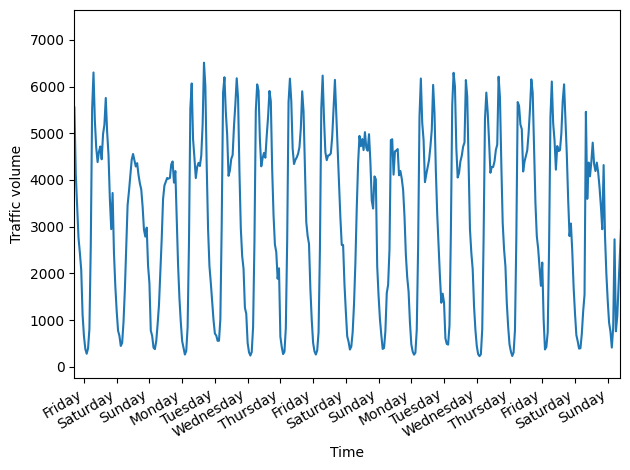

In [16]:
#일별 계절성 확인
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

그림에서 일별 계절성을 확인할 수 있으며, 평일보다 주말에 교통량이 적음을 확인할 수 있다.

데이터의 규모는 시간에 따라 변화가 없어보인다.

### 기온 데이터

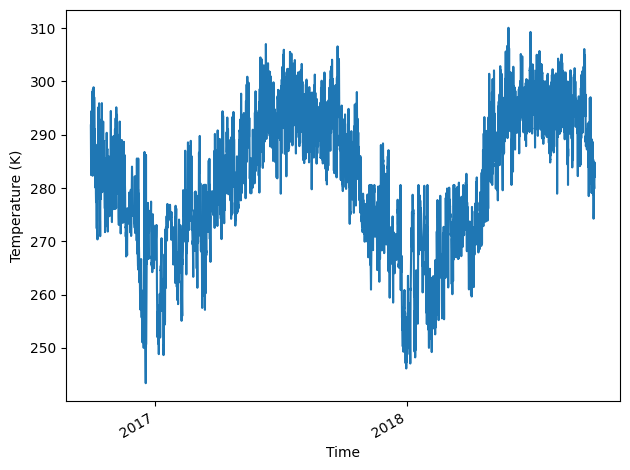

In [17]:
#연간 계절성 확인
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

연말과 연초에는 기온이 낮고 연중에는 기온이 높음을 확인할 수 있다.

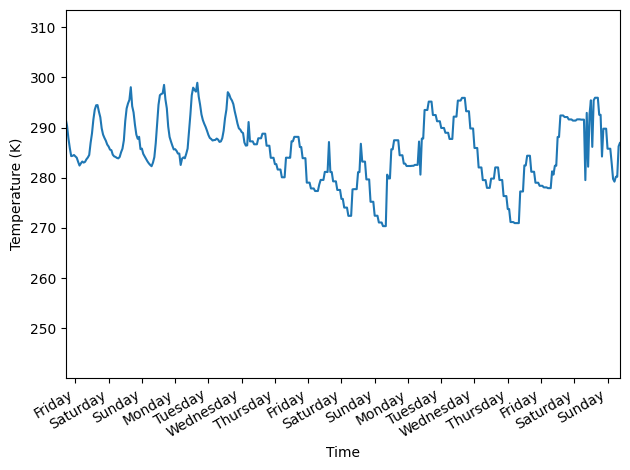

In [18]:
#일별 계절성 확인
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

하루의 시작과 끝이 낮고, 한낮에 최고조임을 확인할 수 있다.

## Feature engineering

### 데이터 통계

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


rain과 snow 데이터는 불필요해 보이므로 제거

In [20]:
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

### 시계열 전처리

In [21]:
#datetime 숫자로 변환
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

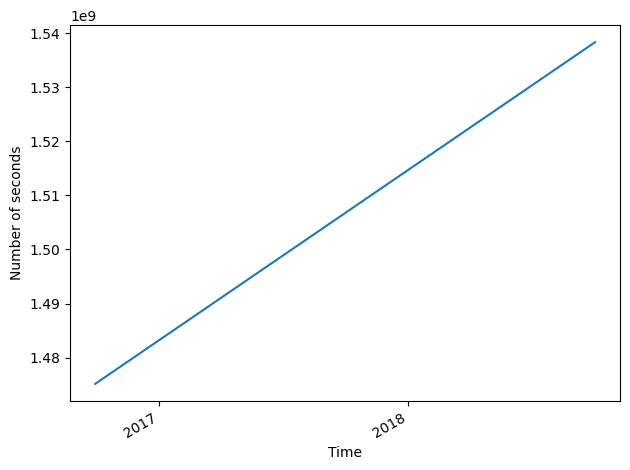

In [22]:
#시각화
fig, ax = plt.subplots()

ax.plot(timestamp_s)
ax.set_xlabel('Time')
ax.set_ylabel('Number of seconds')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

현재 time 데이터는 위 그림과 같이 시간에 대해 선형이므로 시간의 주기성을 표현하기 위한 변환이 필요하다. 

In [23]:
#sine 변환, cosine 변환
day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
df = df.drop(['date_time'], axis=1)

df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,291.75,0,5551.0,8.660254e-01,-0.500000
1,290.36,0,4132.0,7.071068e-01,-0.707107
2,287.86,0,3435.0,5.000000e-01,-0.866025
3,285.91,0,2765.0,2.588190e-01,-0.965926
4,284.31,0,2443.0,1.485292e-12,-1.000000


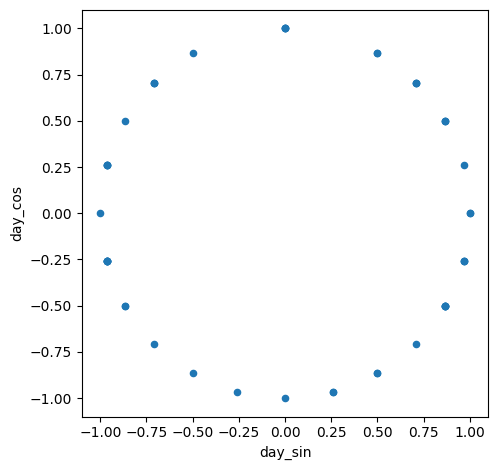

In [24]:
#시간 요소 시각화
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

점들이 원형을 유지하고 있으므로, 하루의 주기적 특성을 유지하고 있다고 판단할 수 있다.

## Dateset split

### 분리

In [25]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((12285, 5), (3510, 5), (1756, 5))

### 스케일링

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

# Creating windows of data

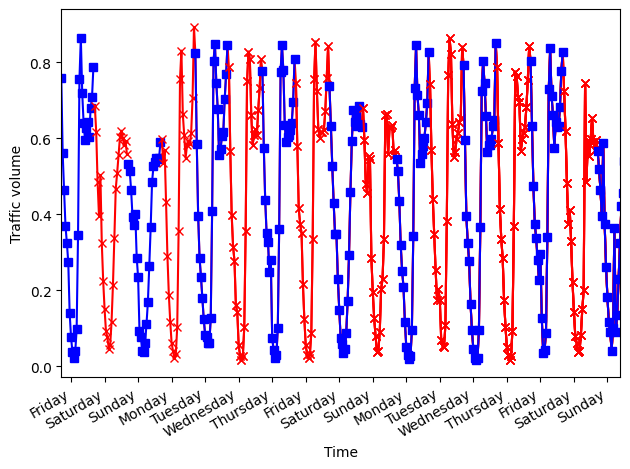

In [27]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

시계열 데이터를 딥러닝에 적용할 경우, 입력과 예측을 한 세트로 하는 데이터 윈도우로 나누어 학습시켜준다. 

### Data window class 정의

In [28]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns #예측하고자 하는 열
    
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        '''
        입력과 레이블로 윈도우 분할하는 함수
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        '''
        입력, 예측값, 실제값 도식화하는 함수
        '''
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(max_subplots, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions', c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        '''
        데이터 집합 텐서로 구성하는 함수
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result